# Handwritten Digit Classification ( Multiclass Classification )

## Import Libraries

In [1]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Input, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

## Define directories

In [2]:
train_dir = "/kaggle/input/hand-written-digit-recognition/train"
test_dir = "/kaggle/input/hand-written-digit-recognition/test"

## Image Preprocesing

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size
image_size = (28, 28)

# Data Augmentation for training data (helps with generalization)
train_datagen = ImageDataGenerator(
    rescale=1./255,          
    zoom_range=0.2, 
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=10,     
)

# Just rescale pixel values for the validation and test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data from directory
train_generator = train_datagen.flow_from_directory(
    train_dir,           
    target_size=image_size,         
    batch_size=32,
    color_mode='grayscale',
    class_mode='sparse'            
)

# Load test data from directory
test_generator = test_datagen.flow_from_directory(
    test_dir,           
    target_size=image_size,        
    batch_size=32,
    color_mode='grayscale',
    class_mode='sparse',
    shuffle=False
)

# Check class labels to ensure proper mapping
print(train_generator.class_indices)

Found 40000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}


In [4]:
# Compute class weights for imbalanced datasets
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

## Build CNN model

In [5]:
digit_model = Sequential([
    Input(shape=(28, 28, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')  # 10 digits (0-9)
])

## Model Compilation and Callbacks

In [6]:
optimizer = Adam(learning_rate=0.001)
digit_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [7]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
checkpoint = ModelCheckpoint("digit_model.keras", monitor='val_accuracy', save_best_only=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [8]:
# Train the model
history = digit_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stopping, checkpoint, lr_scheduler]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1243/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - accuracy: 0.6842 - loss: 0.9649
Epoch 1: val_accuracy improved from -inf to 0.11970, saving model to digit_model.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 358s 280ms/step - accuracy: 0.6848 - loss: 0.9632 - val_accuracy: 0.1197 - val_loss: 8.2171 - learning_rate: 0.0010
Epoch 2/50
1243/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8511 - loss: 0.4780
Epoch 2: val_accuracy improved from 0.11970 to 0.93620, saving model to digit_model.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 88s 70ms/step - accuracy: 0.8512 - loss: 0.4778 - val_accuracy: 0.9362 - val_loss: 0.2024 - learning_rate: 0.0010
Epoch 3/50
1243/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8847 - loss: 0.3678
Epoch 3: val_accuracy improved from 0.93620 to 0.95790, saving model to digit_model.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 91s 72ms/step - accuracy: 0.8847 - loss: 0.3677 - val_accuracy: 0.9579 - val_loss: 0.1300 - learning_rate: 0.0010
Epoch 4/50
1243/1250 ━━━━━━━━━━━━━━━━━━

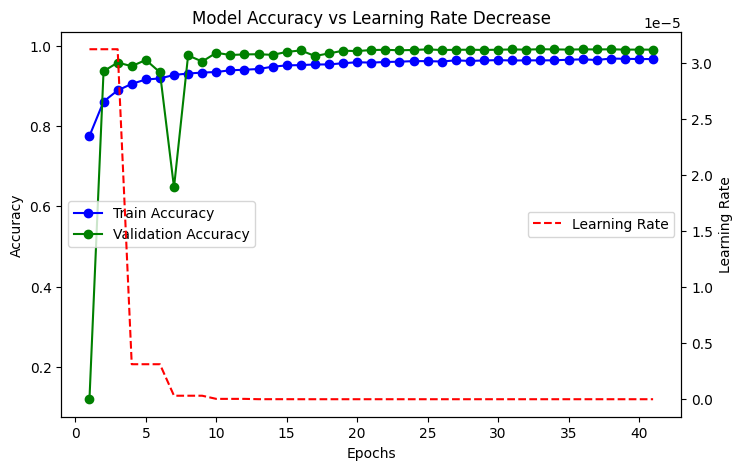

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

# Extract accuracy and validation accuracy from training history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Extract learning rates used at each epoch
lrs = [K.get_value(digit_model.optimizer.learning_rate)]  
for i in range(1, len(history.epoch)):  
    lrs.append(lrs[-1] * 0.1 if (i % 3 == 0 and i > 0) else lrs[-1])  # Simulating ReduceLROnPlateau effect

epochs = np.arange(1, len(accuracy) + 1)

# Plot Model Accuracy vs Learning Rate
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot accuracy curve
ax1.plot(epochs, accuracy, 'b-o', label='Train Accuracy')
ax1.plot(epochs, val_accuracy, 'g-o', label='Validation Accuracy')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.set_title("Model Accuracy vs Learning Rate Decrease")
ax1.legend(loc="center left")

# Plot learning rate on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(epochs, lrs, 'r--', label='Learning Rate')
ax2.set_ylabel("Learning Rate")
ax2.legend(loc="center right")

plt.show()

In [10]:
# Evaluate the model
test_loss, test_acc = digit_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9896 - loss: 0.0303
Test Accuracy: 99.02%
Test Loss: 0.0287


Generating confusion matrix...
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step


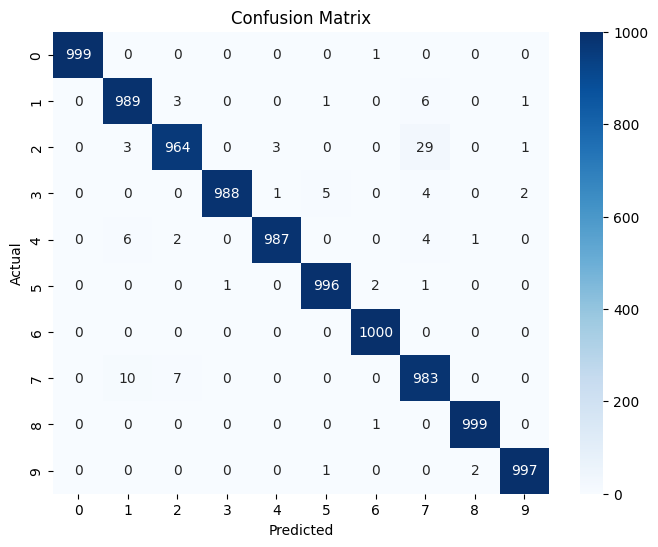

Script execution completed successfully!


In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
print("Generating confusion matrix...")
y_pred = np.argmax(digit_model.predict(test_generator), axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Script execution completed successfully!")

In [12]:
digit_model.save("digit_detection_model.h5")

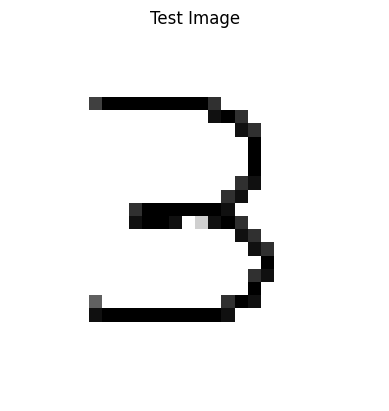

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
Predicted Class: 3


In [17]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the trained model
model_path = "/kaggle/input/handwritten_digit-_detection_model/keras/default/1/digit_detection_model.h5"
digit_model = load_model(model_path)

# Load and preprocess the image
image_path = "/kaggle/input/digit-test-data/digit_data_test/two_1.png"  # Update with your image path
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
img = cv2.resize(img, (28, 28))  # Resize to match model input
img = img / 255.0  # Normalize pixel values
img = np.expand_dims(img, axis=0)  # Add batch dimension
img = np.expand_dims(img, axis=-1)  # Convert to shape (1, 28, 28, 1)

# Remove batch dimension (1, 28, 28, 1) → (28, 28)
img_display = np.squeeze(img, axis=0)

# Show the grayscale image correctly
plt.imshow(img_display, cmap="gray")  # Use cmap="gray" for grayscale images
plt.axis("off")
plt.title("Test Image")
plt.show()

# Predict using the model
prediction = digit_model.predict(img)
confidence = prediction[0][0] * 100

print(f"Predicted Class: {np.argmax(prediction)}")
